In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap 

from math import gamma 
from collections import Counter

import scipy
import seaborn as sns

# 2.1 Binary Variables

<h3>
    $$Bern(x|\mu) = \mu^x(1-\mu)^{1-x}$$ <br>
    <br>
    $$Beta(\mu|a,b) = \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\mu^{a-1}(1-\mu)^{b-1}$$
</h3>

In [2]:
class Binary():
    # posterior distribution for mu 
    def __init__(self,a = 3,b = 3): 
        self.l = a
        self.m = b
    
    def fit(self,X):
        #:param X: 1-D array (N_samples),values should be 0 or 1
        l = np.sum(X)
        m = len(X) - l 
        self.l += l 
        self.m += m
        
    def plot(self):
        x = np.linspace(0,1,100)
        p = np.power(x,self.l-1)*np.power(1 - x,self.m-1)
        p /= p.sum()*0.01
        fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize=(7,5))
        axes.plot(x,p)
        axes.set_title(f"Beta(a={self.l},b={self.m})")
        plt.show()     

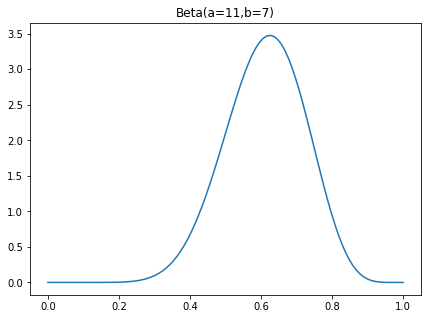

In [3]:
bern = Binary()
X = np.array([1,0,0,0,1,1,1,1,1,1,0,1])
bern.fit(X)
bern.plot()

# 2.2 Multinomial Variables

<h3>
    $$p(\boldsymbol{x}|\boldsymbol{\mu}) = \Pi_{k=1}^K \mu_k^{x_k}$$ <br> 
    <br>
    $$Dir(\boldsymbol{\mu}|\boldsymbol{\alpha}) = \frac{\Gamma(\alpha_0)}{\Gamma(\alpha_1) \cdots \Gamma(\alpha_K)}
    \Pi_{k=1}^K \mu_k^{\alpha_k-1}$$
</h3>

In [4]:
class Multi():
    # posterior distribution for mu
    def __init__(self,K,alpha=None):
        self.K = K 
        self.alpha = alpha if alpha else np.array([1/K]*K)
    
    def fit(self,X):
        #:params X: 2-D array (N_samples,K),values should be 0 or 1 
        N = X.shape[0]
        m = X.sum()
        self.alpha += m/N

# 2.3 The Gaussian Distribution

<h3>
    $$\mathcal{N}(x|\mu,\sigma^2) = \sqrt{\frac{1}{2\pi\sigma^2}}\exp{(-\frac{(x - \mu)^2}{2\sigma^2})}$$<br>
    <br>
    $$\mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu},\boldsymbol{\Sigma}) = \sqrt{\frac{1}{(2\pi)^D|\Sigma|}}\exp{(-\frac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu})^T\Sigma^{-1}(\boldsymbol{x} - \boldsymbol{\mu}))}$$
</h3>

In [5]:
class Gaussian1D():
    # posterior distribution for mu
    def __init__(self,mu=0,sigma=1):
        self.mu = mu
        self.sigma = sigma
    
    def fit(self,X):
        #:params X: 1-D array (N_samples)
        N = len(X)
        mu_ml = X.mean()
        sigma_ml = X.var()
        self.mu = sigma_ml/(N*self.sigma + sigma_ml)*self.mu + N*self.sigma/(N*self.sigma + sigma_ml)*mu_ml
        self.sigma = 1/(1/self.sigma + N/sigma_ml)
    
    def plot(self):
        x = np.linspace(self.mu - self.sigma*1.5,self.mu + self.sigma*1.5,100)
        p = np.exp(-(x - self.mu)**2/2/self.sigma)
        p /= p.sum()*0.01
        fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize=(7,5))
        axes.plot(x,p)
        axes.set_title(f"$Gauss(\mu={self.mu:.2f},\sigma^2={self.sigma:.2f})$")
        plt.show()      

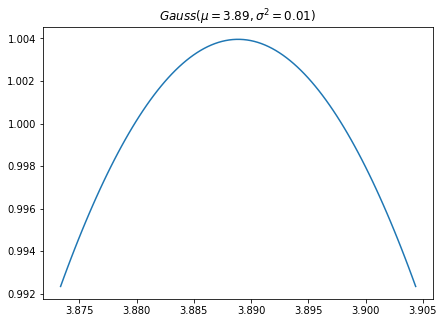

In [6]:
gauss = Gaussian1D()
X = np.random.randn(100) + 4
gauss.fit(X)
gauss.plot()

## Student's t-distribution 

In [7]:
def plot_student(mu,lamda,nu):
    x = np.linspace(mu - 1/lamda*5,mu + 1/lamda*5,100)
    p = np.power(1 + lamda*(x - mu)**2/nu,-(nu + 1)/2)
    p /= p.sum()*0.01 
    fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize=(7,5))
    axes.plot(x,p)
    axes.set_title(f"Student's t-distribution($\mu$={mu:.2f},$\lambda$={lamda:.2f},$\\nu$={nu:.2f})")
    plt.show()

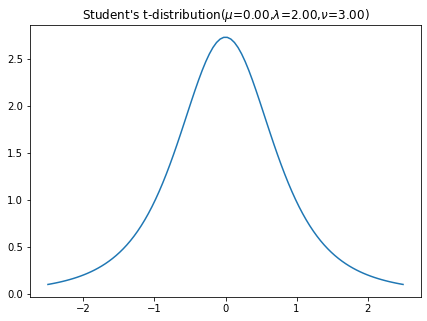

In [8]:
plot_student(0,2,3)

# 2.5 Nonparametric Methods 

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


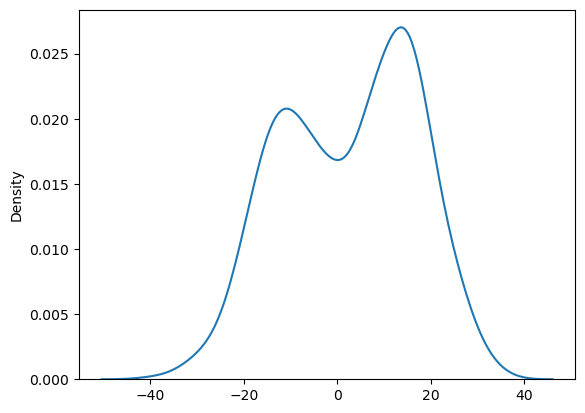

In [7]:
# 1000 samples of first distribution

n = 1000  
mu = [-9, 15]
sigma = [9, 7]
samples1 = []
for i in range(n): 
    Z = np.random.choice([0,1]) 
    samples1.append(np.random.normal(mu[Z], sigma[Z]))
    
sns.distplot(samples1, hist=False)
plt.show()

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


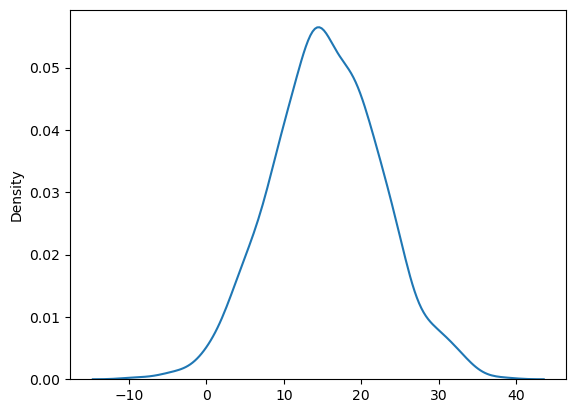

In [8]:
# 1000 samples of second distribution

n = 1000 
mu1 = 15
sigma1 = 7
samples2 = []
for i in range(n): 
    samples2.append(np.random.normal(mu1, sigma1))
                    
sns.distplot(samples2, hist=False)
plt.show()

# histogram methods for density estimation
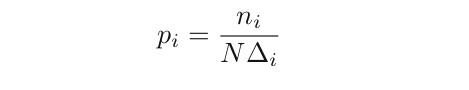

In [9]:
class Histogram():
    def __init__(self,delta=0.5):
        self.delta = delta 
    
    def fit(self,X):
        self.X = X 
        self.maximum = max(X)
        self.minimum = min(X) 
    
    def plot(self, show_main = True):
        bins = int((self.maximum - self.minimum)/self.delta) 
        
        fig,axes = plt.subplots(nrows = 1,ncols = 1)
        self.n, self.bin, self.p = axes.hist(self.X,bins = bins, density = True, color = 'Purple')
        axes.set_title("Hist(delta = {})".format(self.delta))
        
        if show_main :
            sns.distplot(self.X, hist=False)
        plt.show()

        return self.n, self.bin
    
    def myplt(self, show_main = True):
        bin_num = int((self.maximum - self.minimum)/self.delta)
        bins = [round(self.minimum, 8)]
        
        for i in range (bin_num):
            bins.append(round(bins[i] + self.delta, 8)) 
        
        p = [0]*bin_num
        x = ['0']*bin_num
        
        for item in self.X:
            if (bins[0] <= item and item < bins[len(bins)-1]):
                for i in range (len(bins)-1):
                    if (bins[i] <= item and item < bins[i+1]):
                        p[i] +=1
                        x[i] = str(int(bins[i]))
                        break
        #print (x)

        for i in range (len(p)):
            p[i] /= (self.delta * len(self.X))
        
        merged_list = [(p[i], x[i]) for i in range(0, len(p))]
        sorted(merged_list, key=lambda x: x[1])
        
        for i in range (len (merged_list)):
            p[i] = merged_list[i][0]
            x[i] = merged_list[i][1]
        
        p = np.array(p)
        #print (len(p))
        #print (bin_num)
        
        fig,axes = plt.subplots(nrows = 1,ncols = 1)
        axes.set_title("Hist(delta = {})".format(self.delta))    
        axes.bar(bins[:len(bins) - 1],p,width=self.delta,color='Purple')
        if show_main :
            sns.distplot(self.X, hist=False)
        plt.show()
        
                        
    def predict(self, X):
        if (self.bin[0] <= X and X < self.bin[len(self.bin) - 1]):
            for i in range (len(self.bin) - 1):
                if (self.bin[i] <= X and X < self.bin[i+1]):
                    return self.n[i]
        else:
            return 0


Enter 1 or 2 : 1
Enter T or F : f


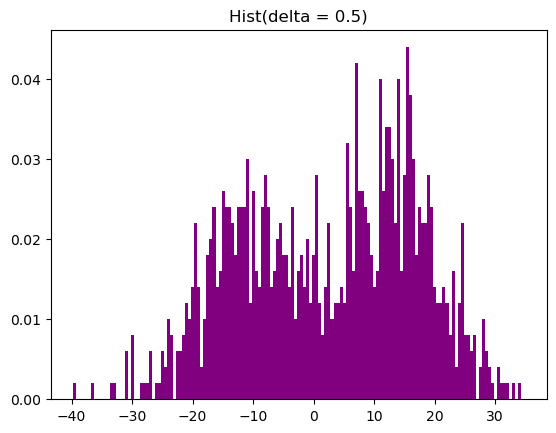

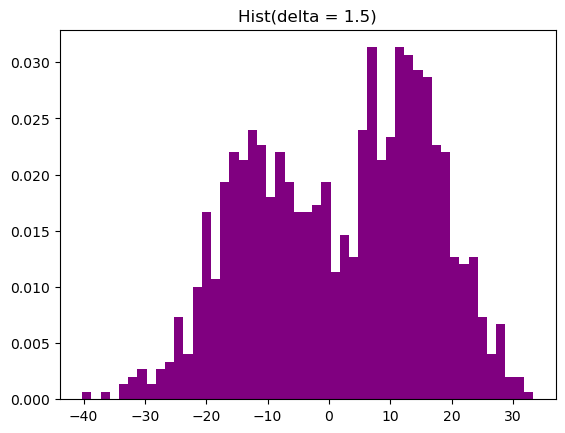

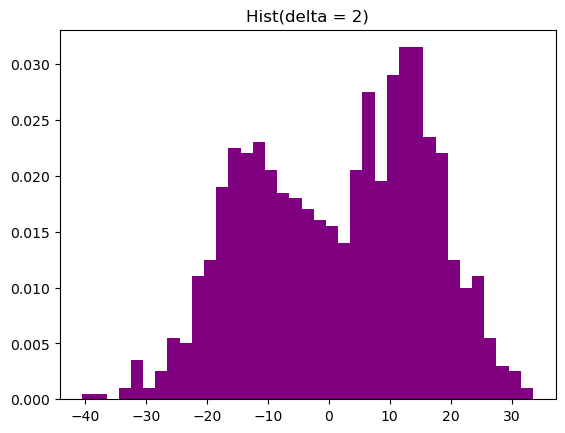

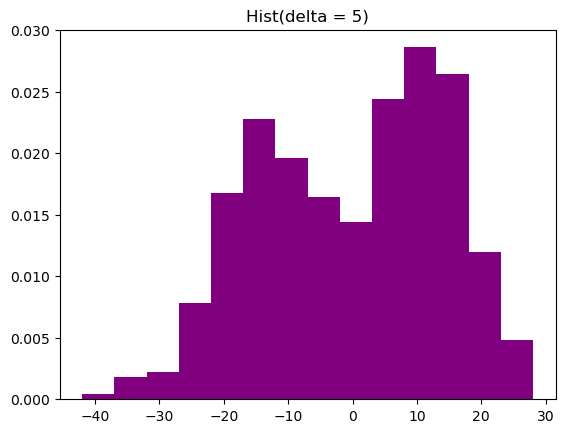

In [10]:
delta = [0.5, 1.5, 2, 5]

which_sample = input ('Enter 1 or 2 : ')
show_main = input ('Enter T or F : ')

if which_sample == '1':
    sample = samples1
else:
    sample = samples2
    
for d in delta:
    if show_main == 't':
        hist = Histogram(d)
        h1ist.fit(sample)
        hist.myplt()
    elif show_main == 'f':
        hist = Histogram(d)
        hist.fit(sample)
        hist.myplt(False)

Enter 1 or 2 : 1
Enter t or f : t


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


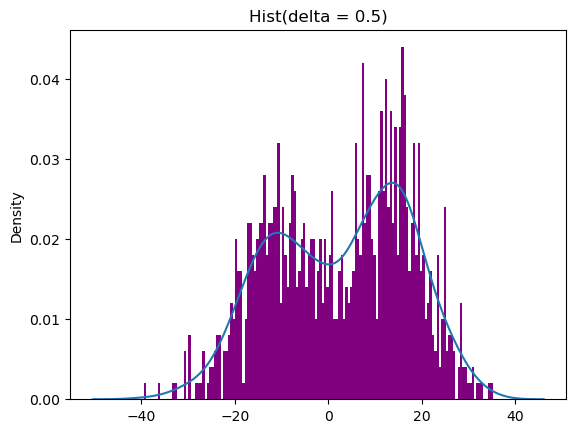

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


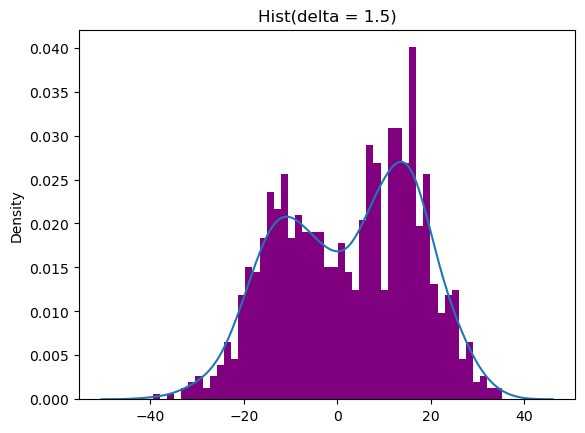

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


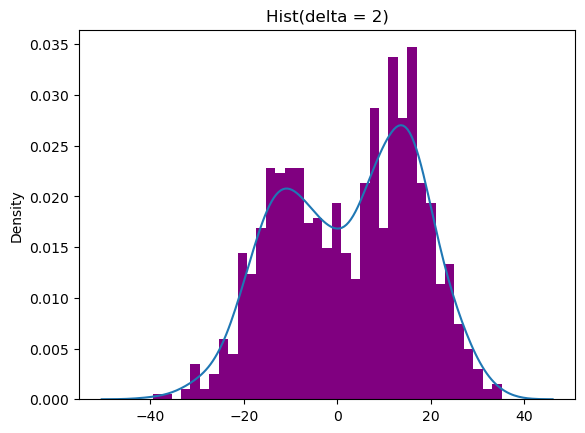

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


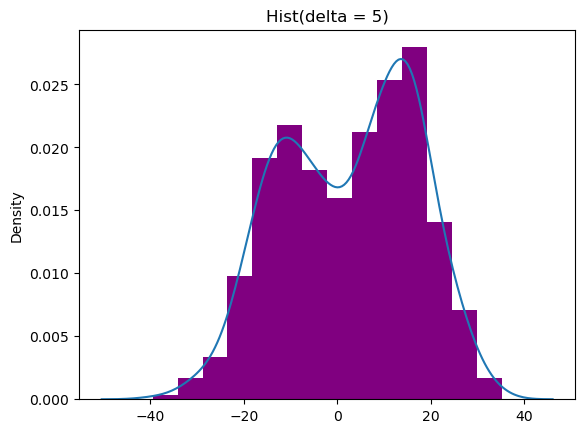

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


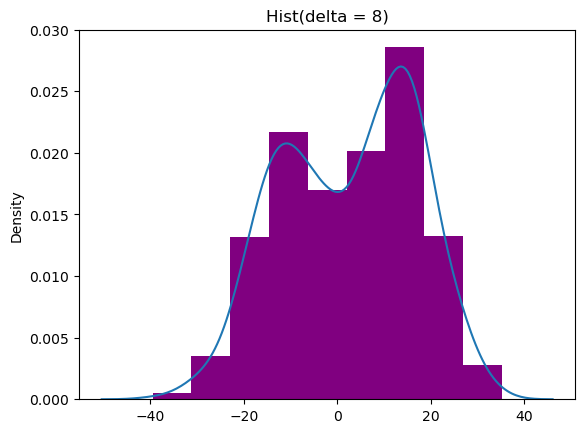

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


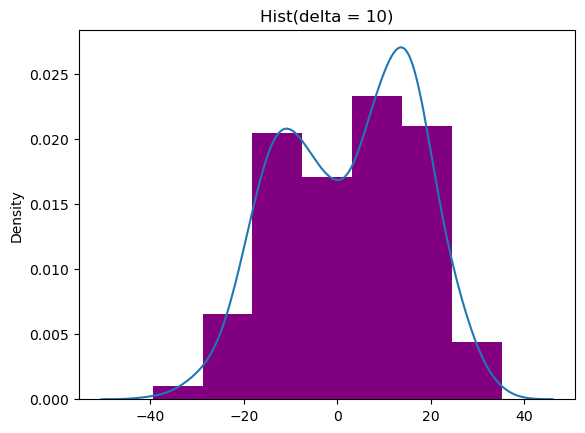

In [11]:
delta = [0.5, 1.5, 2, 5, 8, 10]

which_sample = input ('Enter 1 or 2 : ')
show_main = input ('Enter t or f : ')

if which_sample == '1':
    sample = samples1
else:
    sample = samples2
    
for d in delta:
    if show_main == 't':
        hist = Histogram(d)
        hist.fit(sample)
        hist.plot()
    elif show_main == 'f':
        hist = Histogram(d)
        hist.fit(sample)
        hist.plot(False)

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


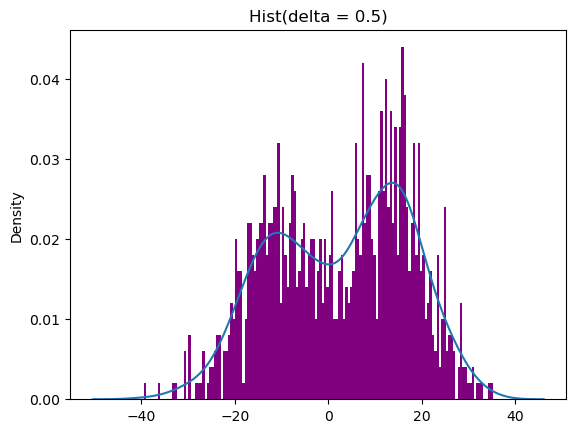

Prediction when delta is 0.5 : 0.015968489441004718


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


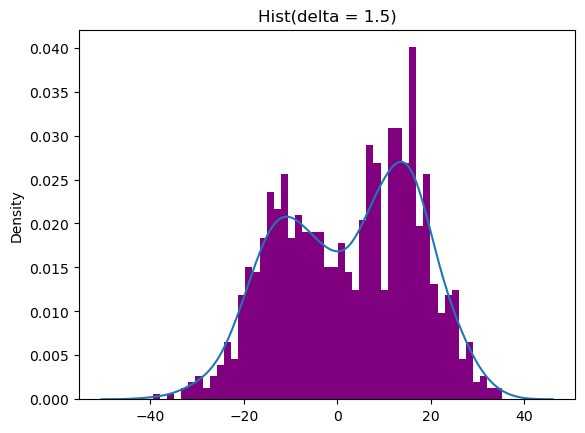

Prediction when delta is 1.5 : 0.01312845608404751


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


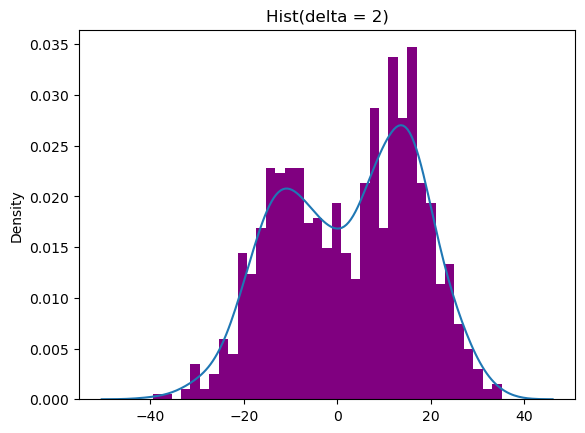

Prediction when delta is 2 : 0.01933098176457197


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


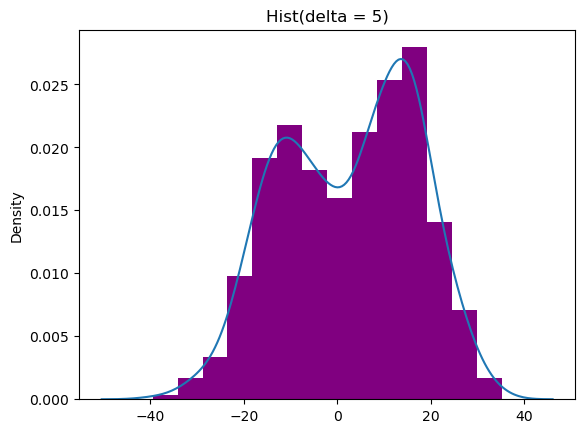

Prediction when delta is 5 : 0.014066202947193771


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


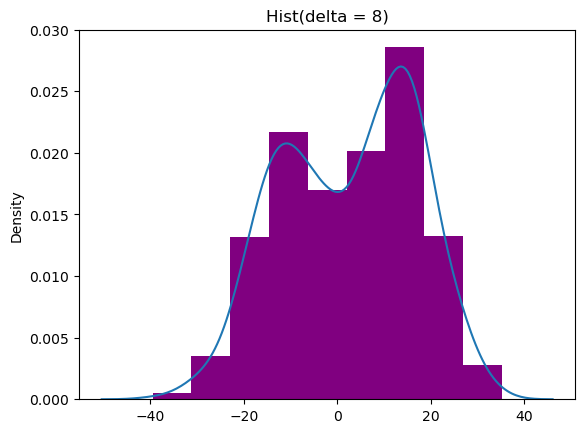

Prediction when delta is 8 : 0.013262419921639821


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


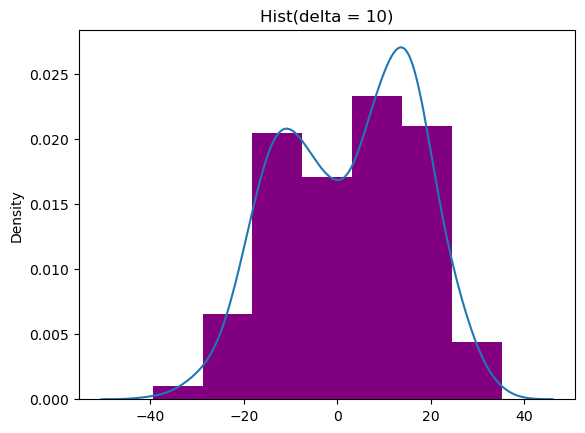

Prediction when delta is 10 : 0.021005529734476017


In [12]:
delta = [0.5, 1.5, 2, 5, 8, 10]
new_data = 20

#pdf_probability = scipy.stats.norm.pdf (new_data, loc = 15, scale = 7)

for d in delta :
    hist = Histogram(d)
    hist.fit(samples1)
    hist.plot()
    print( "Prediction when delta is {} : {}".format(d,hist.predict(new_data)))
    #print("real value is : ", pdf_probability)

## Kernel density estimators 


In [13]:
class KDE():
    def __init__(self, h = 1, interval = 100):
        self.h = h
        self.interval = interval
    
    def fit(self,X):
        self.X = X
        self.minimum = min(X)
        self.maximum = max(X)
        self.X_S = np.linspace(self.minimum-self.h,self.maximum+self.h, self.interval)
        
    def KDE_basic (self):
        xs = self.X_S
        h = self.h
        p = [0]*len(xs)
        
        for xn in self.X:
            for i, x in enumerate(xs):
                if abs(x - xn) <= h /2:
                    p[i] +=1
        
        for i in range (len(p)):
            p[i] /= (h * len(self.X))
        
        
        fig,axes = plt.subplots(nrows = 1,ncols = 1)
        axes.plot(xs,p, color = 'Purple')
        axes.set_title("KDE Basic (h = {})". format(h))
        sns.distplot(self.X, hist=False)
        plt.show()

    def KDE_gauss (self):
        xs = self.X_S
        h = self.h
        p = [0]*len(xs)

        for xn in self.X:
            for i, x in enumerate(xs):
                p[i] += (np.exp(-((x - xn) ** 2)/(2 * h ** 2)))
        #print (p)
        
        for i in range (len(p)):
            p[i] /= len(self.X) * ((2 * np.pi * (h ** 2)) **0.5)
        #print (p)
        
        fig,axes = plt.subplots(nrows = 1,ncols = 1)
        axes.plot(xs,p, color = 'red')
        axes.set_title("KDE Gaussian (h = {})". format(h))
        
        sns.distplot(self.X, hist=False, color ='green')
        plt.show()
        
    def prediction(self, X, kernel = 'basic'):
        p = 0
        if kernel == 'basic':
            for i in range (len(self.X)):
                if abs(X - self.X[i]) <= self.h / 2:
                    p +=1
            p /= (self.h * len(self.X))
            
        elif kernel == 'gauss':
            for i in range (len(self.X)):
                p += (np.exp(-((X - self.X[i]) ** 2)/(2 * self.h ** 2)))
            p /= len(self.X) * ((2 * np.pi * (self.h ** 2)) **0.5)
        
        return p

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


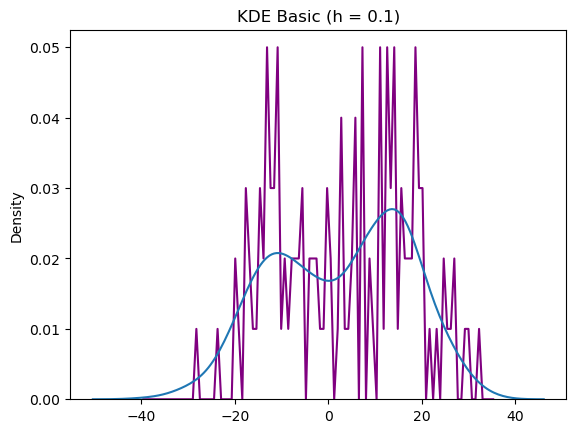

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Prediction when h is 0.1 : 0.01


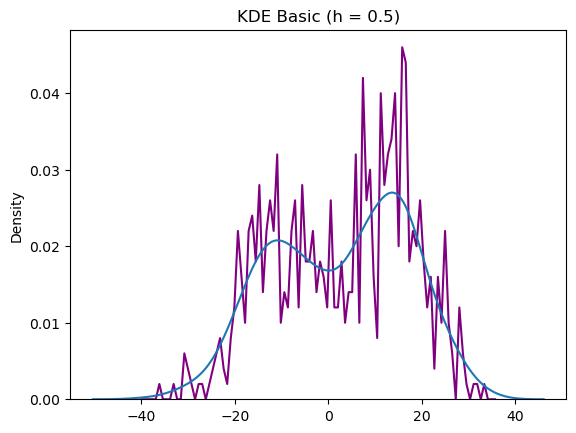

Prediction when h is 0.5 : 0.002


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


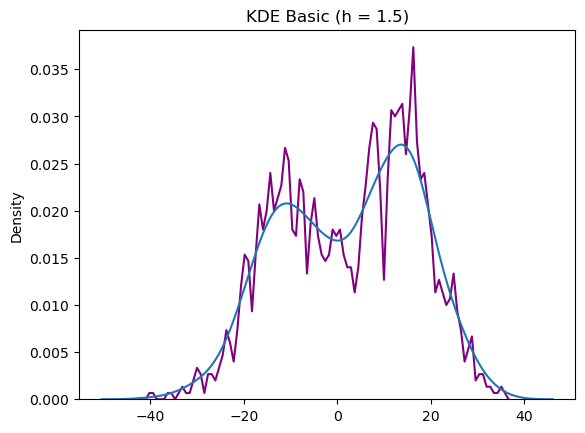

Prediction when h is 1.5 : 0.0026666666666666666


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


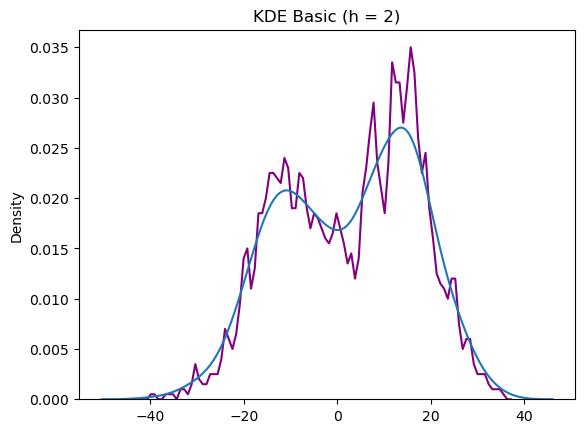

Prediction when h is 2 : 0.0025


In [14]:
h = [0.1, 0.5, 1.5, 2]
new_data = 30

for elem in h:
    KDE_basic = KDE(elem)
    KDE_basic.fit(samples1)
    KDE_basic.KDE_basic()
    KDE_basic.prediction(new_data)
    print( "Prediction when h is {} : {}".format(elem,KDE_basic.prediction(new_data)))

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


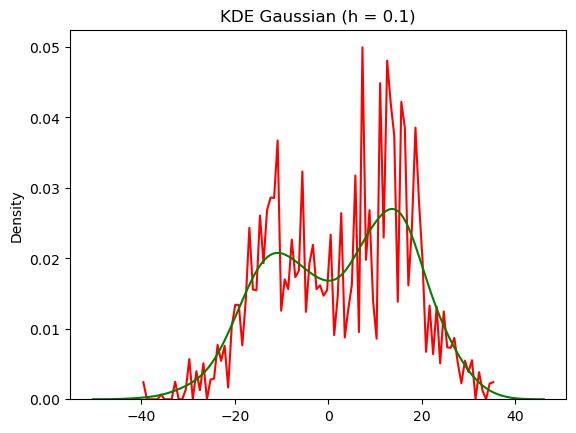

Prediction when h is 0.1 : 0.01


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


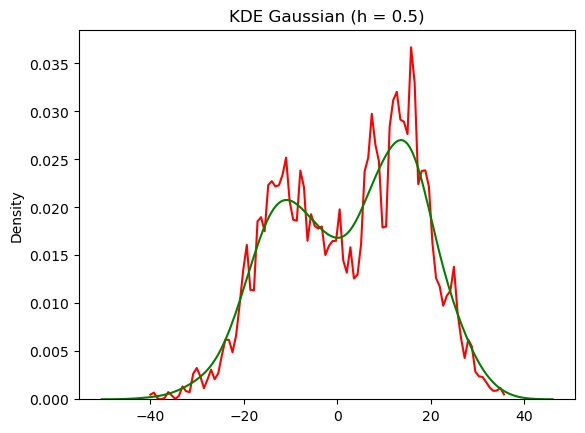

Prediction when h is 0.5 : 0.002


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


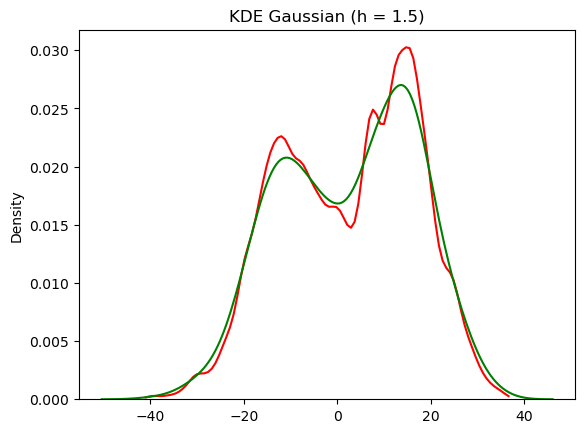

Prediction when h is 1.5 : 0.0026666666666666666


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


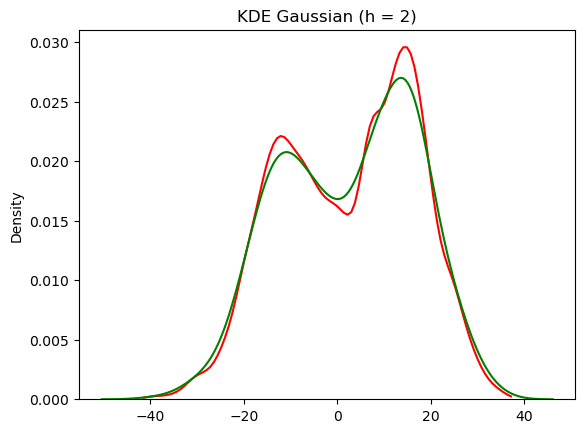

Prediction when h is 2 : 0.0025


In [15]:
h = [0.1, 0.5, 1.5, 2]
new_data = 30

for elem in h:
    KDE_gauss = KDE(elem)
    KDE_gauss.fit(samples1)
    KDE_gauss.KDE_gauss()
    KDE_gauss.prediction(new_data, 'gauss')
    print( "Prediction when h is {} : {}".format(elem,KDE_gauss.prediction(new_data)))

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


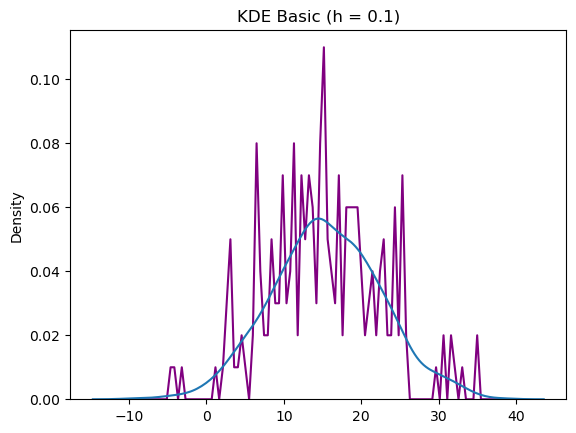

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Prediction when h is 0.1 : 0.01
real value is :  0.005737297205843303


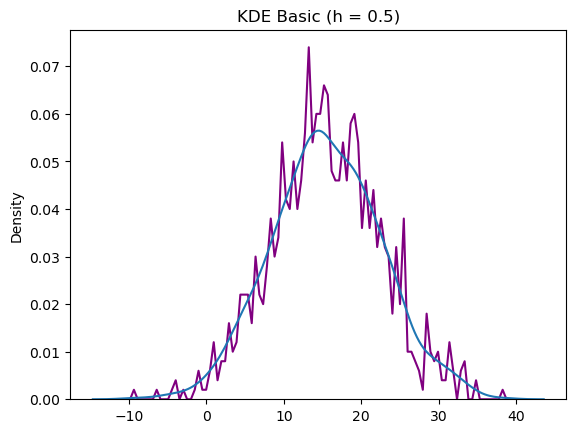

Prediction when h is 0.5 : 0.008
real value is :  0.005737297205843303


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


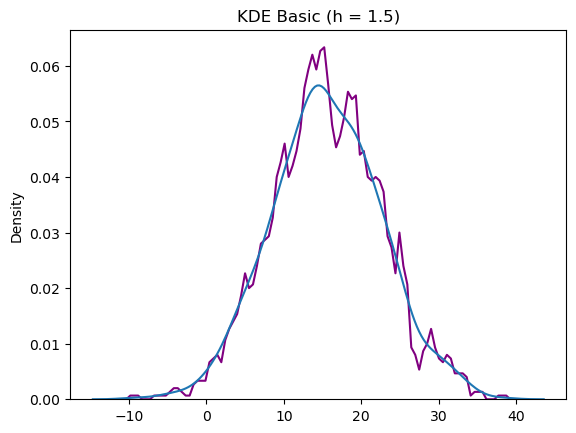

Prediction when h is 1.5 : 0.007333333333333333
real value is :  0.005737297205843303


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


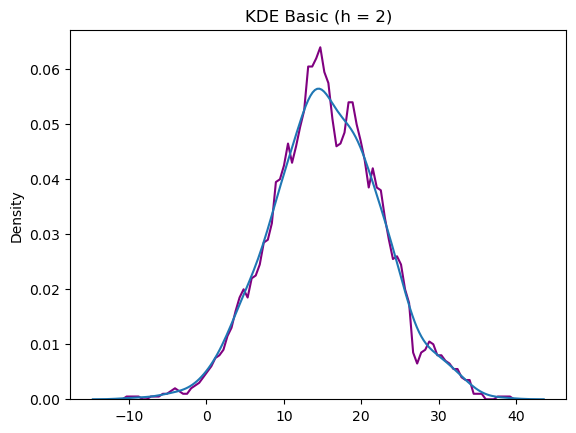

Prediction when h is 2 : 0.007
real value is :  0.005737297205843303


In [16]:
h = [0.1, 0.5, 1.5, 2]
new_data = 30
pdf_probability = scipy.stats.norm.pdf (new_data, loc = 15, scale = 7)

for elem in h:
    KDE_basic = KDE(elem)
    KDE_basic.fit(samples2)
    KDE_basic.KDE_basic()
    KDE_basic.prediction(new_data)
    print( "Prediction when h is {} : {}".format(elem,KDE_basic.prediction(new_data)))
    print("real value is : ", pdf_probability)

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


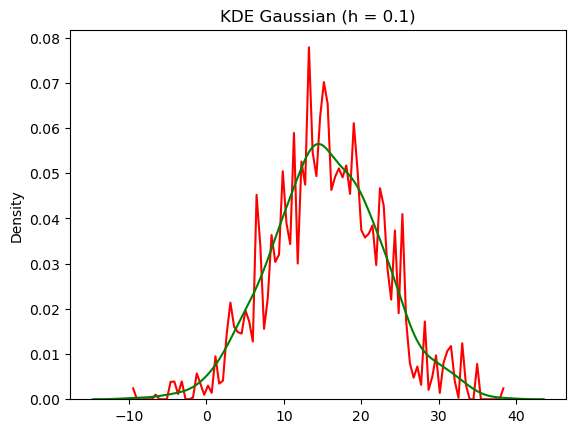

Prediction when h is 0.1 : 0.00840594043016474
real value is :  0.005737297205843303


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


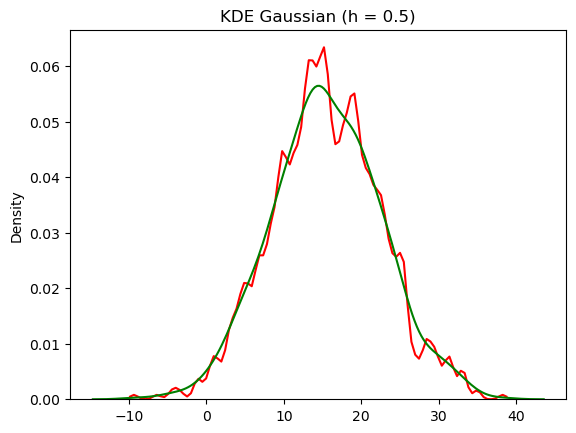

Prediction when h is 0.5 : 0.007251587921011974
real value is :  0.005737297205843303


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


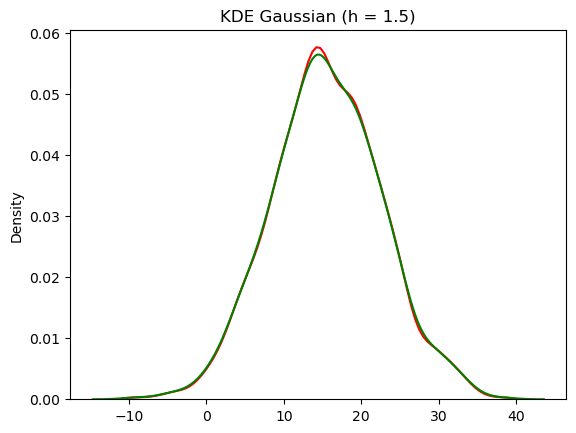

Prediction when h is 1.5 : 0.0079153324989194
real value is :  0.005737297205843303


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


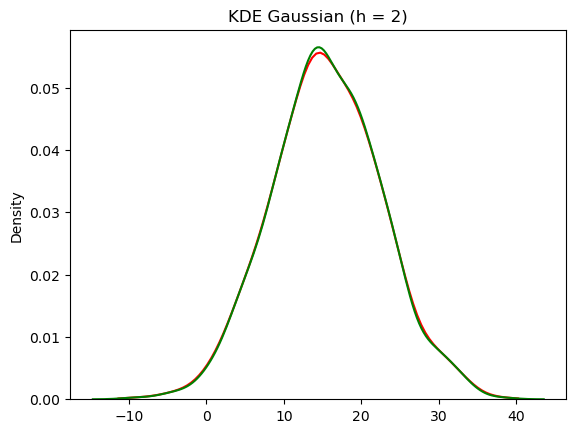

Prediction when h is 2 : 0.00793471019582124
real value is :  0.005737297205843303


In [17]:
h = [0.1, 0.5, 1.5, 2]
new_data = 30
pdf_probability = scipy.stats.norm.pdf (new_data, loc = 15, scale = 7)

for elem in h:
    KDE_gauss = KDE(elem)
    KDE_gauss.fit(samples2)
    KDE_gauss.KDE_gauss()
    print( "Prediction when h is {} : {}".format(elem,KDE_gauss.prediction(new_data, 'gauss')))
    print("real value is : ", pdf_probability)

## Nearest-neighbor methods
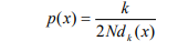

In [18]:
class KNN():
    def __init__(self, k = 3, interval = 100):
        self.k = k
        self.interval = interval
        
    def fit(self, X):
        self.X = X
        self.minimum = min(X)
        self.maximum = max(X)
        self.X_S = np.linspace(self.minimum, self.maximum, self.interval)
        
    def kNearest(self):
        xs = self.X_S
        k = self.k
        p = [0]*len(xs)
        
        for i, x in enumerate(xs):
            distance = list()
            for xn in self.X:
                distance.append(abs(x - xn))
            distance.sort()
            p[i] = k / (2 * len(self.X) * distance[k-1])
            
        fig,axes = plt.subplots(nrows = 1,ncols = 1)
        axes.plot(xs,p, color = 'Purple')
        axes.set_title("KNN (k = {})". format(k))
        sns.distplot(self.X, hist=False)
        plt.show()
        
    def prediction(self, X, k = 50):
        p = list()
        
        for xs in self.X:
            p.append(abs(X - xs))
        
        p.sort()
        
        pred = k / (2 * len(self.X) * p[k-1])
    
        return pred

/tmp/ipykernel_40567/632286107.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  p[i] = k / (2 * len(self.X) * distance[k-1])
/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


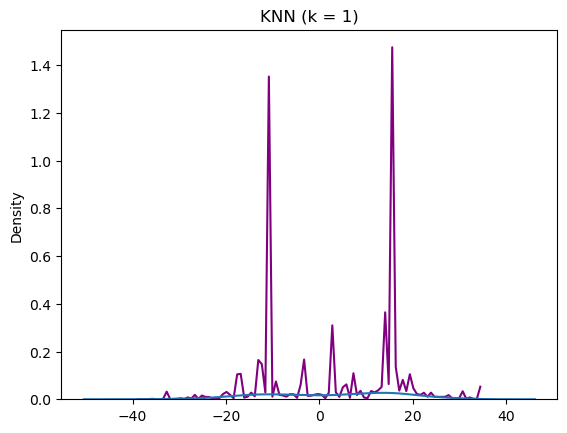

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


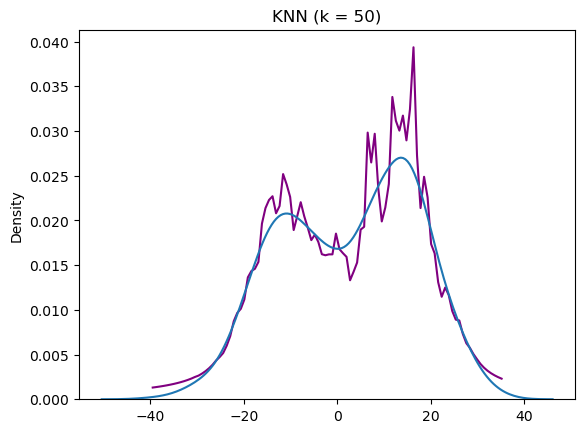

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


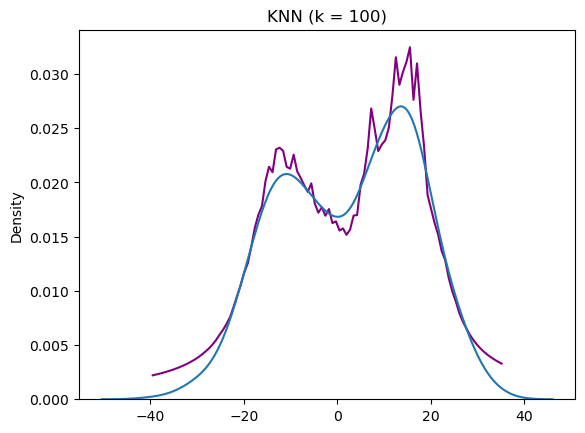

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


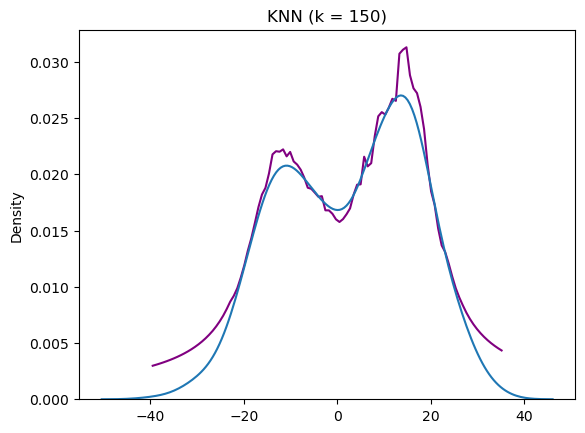

/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


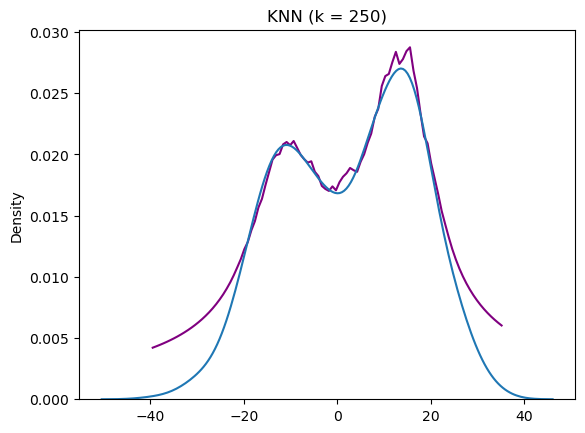

In [19]:
k = [1, 50, 100, 150, 250]
new_data = 10

for elem in k:
    knn = KNN(elem)
    knn.fit(samples1)
    knn.kNearest()

/tmp/ipykernel_40567/632286107.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  p[i] = k / (2 * len(self.X) * distance[k-1])
/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


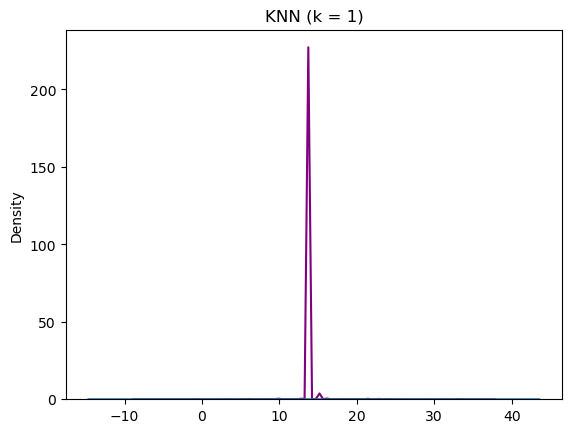

Prediction when k is 1 : 0.014109330000129986
real value is :  0.04415934440272378


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


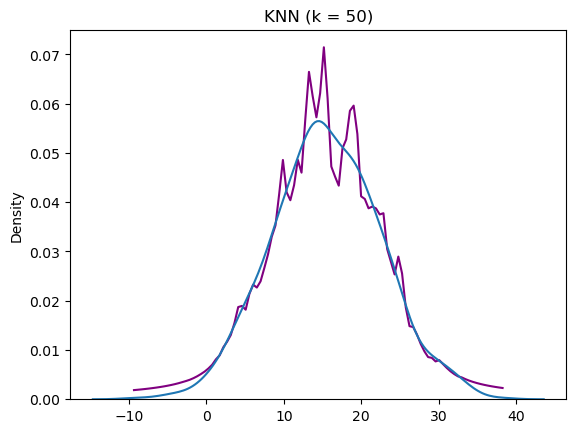

Prediction when k is 50 : 0.049724222961617645
real value is :  0.04415934440272378


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


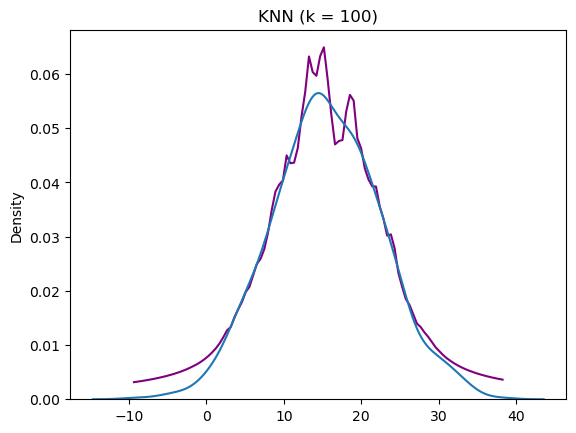

Prediction when k is 100 : 0.04064407405296358
real value is :  0.04415934440272378


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


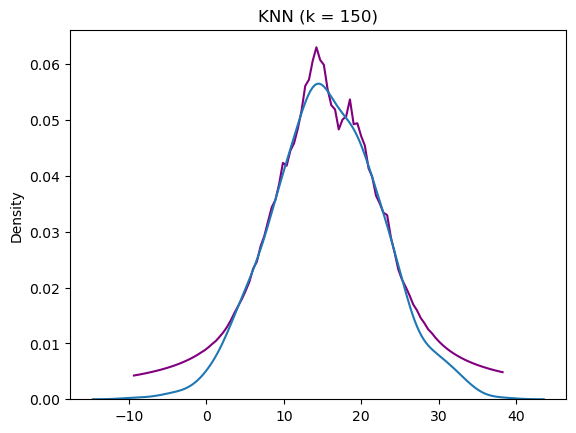

Prediction when k is 150 : 0.040556233500617336
real value is :  0.04415934440272378


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


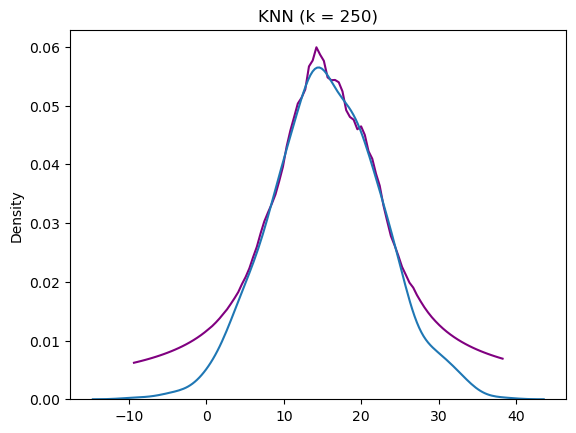

Prediction when k is 250 : 0.04028856946966233
real value is :  0.04415934440272378


/home/negar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


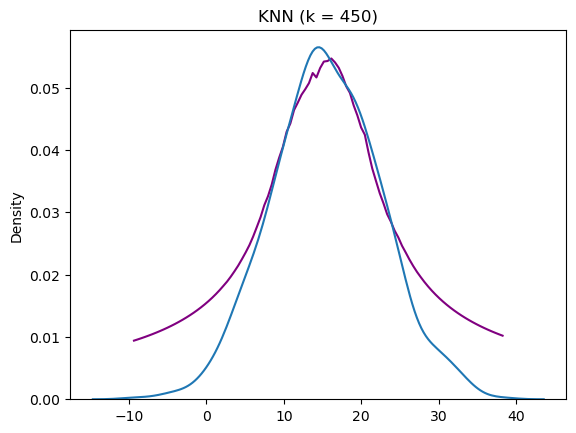

Prediction when k is 450 : 0.041068438778347566
real value is :  0.04415934440272378


In [20]:
k = [1, 50, 100, 150, 250, 450]
new_data = 10

pdf_probability = scipy.stats.norm.pdf (new_data, loc = 15, scale = 7)

for elem in k:
    knn = KNN(elem)
    knn.fit(samples2)
    knn.kNearest()
    print( "Prediction when k is {} : {}".format(elem,knn.prediction(new_data, elem)))
    print("real value is : ", pdf_probability)

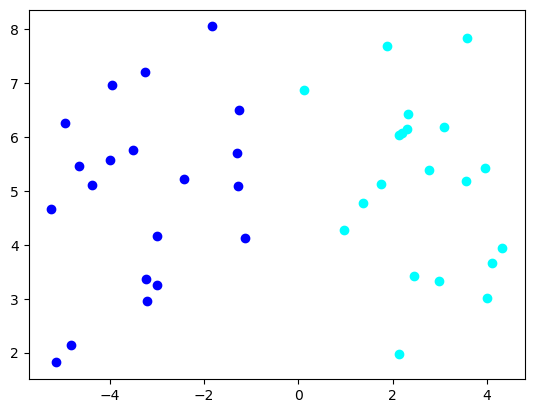

In [21]:
mean1 = np.array([-3, 5])
sigma1 = np.array([[2, 1],
                  [1, 3]])

mean2 = np.array([3, 5])
sigma2 = np.array([[2, -1],
                  [-1, 3]])

sample1 = np.random.multivariate_normal(mean1, sigma1, (20,)) # class 1 # blue
sample2 = np.random.multivariate_normal(mean2, sigma2, (20,)) # class 0 # cyan

s1 = np.ones((20,1))
s2 = np.zeros((20,1))

sample = np.concatenate ((sample1, sample2))
s = np.concatenate ((s1, s2))
#print(s)

plt.scatter(sample1[:, 0], sample1[:, 1], color = 'blue')
plt.scatter(sample2[:, 0], sample2[:, 1], color = 'cyan')
plt.show()

In [22]:
class knnClass():
    def __init__ (self, k = 3):
        self.k = k
        
    def fit (self, x_train, y_train):
        self.X = x_train
        self.Y = y_train
        
    def prediction(self, x_test):
        dist = list()
        for i in range (len(self.X)):
            #print (self.X[i][0])
            #print (x_test[0])
            dist.append([np.sqrt((self.X[i][0] - x_test [0][0])**2 + (self.X[i][1] - x_test [0][1])**2), self.Y[i][0]])
        
        dist = sorted(dist, key = lambda x: x[0])
        counting = []
        for i in range (self.k):
            counting.append(dist[i][1])
        
        cls = max(set(counting), key = counting.count)
        return (dist[:self.k][:], counting, cls)

In [23]:
t = knnClass(1)
t.fit(sample,s)
x = np.array([[-2,6]])
kn, count, cls = t.prediction(x)

print (kn)
count

[[0.7684828135950204, 1.0]]


[1.0]

class1


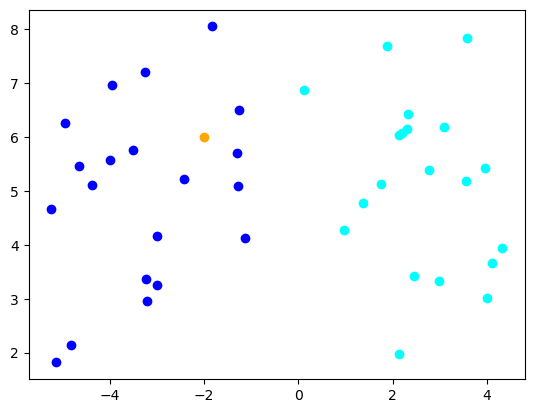

1.0

In [24]:
if cls == 0.0:
    print ('class0')
else:
    print ('class1')

plt.scatter(sample1[:, 0], sample1[:, 1], color = 'blue')
plt.scatter(sample2[:, 0], sample2[:, 1], color = 'cyan')
plt.scatter(x[0][0], x[0][1], color = 'orange')
plt.show()
cls

In [15]:
color = ["red","blue","lightgreen","yellow","orange","purple","pink"] 

class KNeighborClassifier():
    def __init__(self,k=10):
        self.k = k
        
    def fit(self,X,y):
        #:params X: 2-D array (N_samples,2) 
        #:params y: 1-D array (N_samples) label-encoding 
        self.X = X 
        self.y = y
    
    def predict(self,X):
        #:params X: 2-D array (N_samples,2) 
        pred_y = [0]*len(X)
        for i,(a,b) in enumerate(X):
            dist_label = [((a-x)**2+(b-y)**2,label) for (x,y),label in zip(self.X,self.y)]
            dist_label.sort() 
            k_neighbor = [label for d,label in dist_label[:self.k]]
            k_neighbor_label = Counter(k_neighbor).most_common(1)[0][0]
            pred_y[i] = k_neighbor_label
        return np.array(pred_y)
        
    def plot(self):
        cmap = ListedColormap(color[:len(np.unique(self.y))])
        x_min,y_min = self.X.min(axis = 0)
        x_max,y_max = self.X.max(axis = 0) 
        x_min,y_min = x_min-0.1,y_min-0.1
        x_max,y_max = x_max+0.1,y_max+0.1
        x = np.linspace(x_min,x_max,100)
        y = np.linspace(y_min,y_max,100) 
        xs,ys = np.meshgrid(x,y)
        labels = self.predict(np.array([xs.ravel(),ys.ravel()]).T)
        labels = labels.reshape(xs.shape)
        
        plt.contourf(xs,ys,labels,alpha=0.3,cmap=cmap)
        plt.xlim(x_min,x_max)
        plt.ylim(y_min,y_max)
        for idx,label in enumerate(np.unique(self.y)):
            plt.scatter(x=self.X[self.y == label,0],
                        y=self.X[self.y == label,1],
                        alpha=0.8,
                        c=color[idx],
                        label=label)
        plt.legend()
        plt.show()

In [16]:
def load_iris():
    dict = {
        "Iris-setosa": 0,
        "Iris-versicolor": 1,
        "Iris-virginica": 2
    }
    X = []
    y = [] 
    with open("../data/iris.data") as f:
        data = f.read()
    
    for line in data.split("\n"):
        # sepal length | sepal width | petal length | petal width 
        if len(line) == 0:
            continue
        sl,sw,pl,pw,cl = line.split(",")
        rec = np.array(list(map(float,(sl,sw,pl,pw))))
        cl = dict[cl]

        X.append(rec)
        y.append(cl)
    return np.array(X),np.array(y)

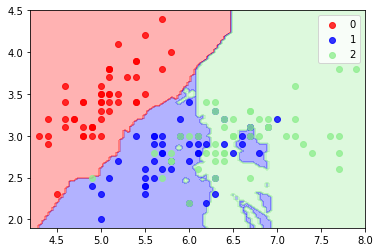

In [17]:
X,y = load_iris()
X = X[:,:2]

knn10 = KNeighborClassifier()
knn10.fit(X,y)
knn10.plot()

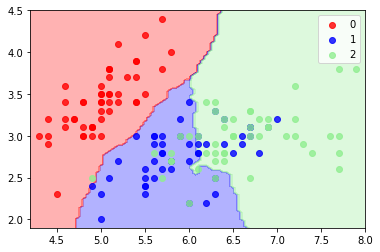

In [18]:
knn30 = KNeighborClassifier(k=30)
knn30.fit(X,y)
knn30.plot()